# Convolutional Neural Networks

# **The lab has two parts. The first part of the lab acts as a tutorial for you to get familiar with PyTorch CNN. In the second part you will have to do some real coding.**

---



This lab expects a basic understanding of pytorch and convolutional networks.

* `torch.nn` documentation http://pytorch.org/docs/master/nn.html
* Convolution animations. Make sure to understand these animations so you can visualize stride, padding, etc. https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
* If you want to look at something more complicated, check out the ResNet implementation in torchvision: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

In [149]:
import torch
import torch.nn.functional as F
from torch import autograd, nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets

## Data Format

Dimension ordering is very important. For pytorch:

* 2D data like images should be `(samples, channels, height, width)` sometimes called "NCHW" or "channels first"
* 1D data like stock prices should be `(samples, channels, time)`
* 2D filters should be `(out_channels, in_channels, height, width)`
* 1D filters should be `(out_channels, in_channels, time)`

Different frameworks (e.g., TensorFlow) use different dimension orderings so be very careful, especially when implementing code or reading data targeted at a different framework.

Note most image data is RGB but some is BGR  or ARGB.

In [150]:
input_image = autograd.Variable(torch.randn(1,3,32,32)) # single 32x32 RGB image
print(input_image.size())
input_signal = autograd.Variable(torch.randn(1,40,100)) # 40 dimensional signal for 100 timesteps
print(input_signal.size())

torch.Size([1, 3, 32, 32])
torch.Size([1, 40, 100])


## Convolutional Layers

The `torch.nn` module provides layers for CNNs. Use in the same way as other modules. Please refer to the documentation for details. Some of the most common layers you will use:

* `torch.nn.Conv2d`
* `torch.nn.ConvTranspose2d`
* `torch.nn.MaxPool2d`
* `torch.nn.AvgPool2d`


In [151]:
# Create layers
layer_c2d = torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5, stride=1, padding=2)
layer_avg = torch.nn.AvgPool2d(kernel_size=32)

In [152]:
# Use layers directly
y = layer_c2d(input_image)
print(y.size())

torch.Size([1, 20, 32, 32])


In [153]:
# Add layers to model
model = torch.nn.Sequential(layer_avg, layer_c2d)
y = model(input_image)
print(y.size())

torch.Size([1, 20, 1, 1])


## Convolutional Functions

The `torch.nn.functional` module provides low-level functions. Depending on what kinds of models you are making, you may never have to use these functions, and use pre-made layers instead. When using the functional module, you need to instantiate parameters yourself.

http://pytorch.org/docs/0.1.12/nn.html#torch-nn-functional

Example low-level functions:

* `F.max_pool2d`
* `F.dropout2d`
* `F.conv2d`

In [154]:
filters = autograd.Variable(torch.randn(20,3,5,5)) # 5x5 filter from 3 dimensions to 20
y=F.conv2d(input_image, filters, padding=2)
print(y.size())

torch.Size([1, 20, 32, 32])


In [155]:
filters = autograd.Variable(torch.randn(256,40,5)) # 5 wide filter from 40 dimensions to 256
y=F.conv1d(input_signal, filters, padding=2)
print(y.size())

torch.Size([1, 256, 100])


For example, if you generate the kernel using a neural network, you will have to use the functional module instead of a standard convolutional layer.

## Padding

Simple 0-padding can be accomplished using the `padding` keyword argument of many functions. Normally, you will be using the same vertical and horizontal padding but you can also pass a tuple `(H,W)`. Padding is applied symmetrically.

In [156]:
inputs = autograd.Variable(torch.randn(1,3,32,32)) # single 32x32 RGB image
print(torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=7, padding=0)(inputs).size())
print(torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=7, padding=1)(inputs).size())
print(torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=7, padding=2)(inputs).size())
print(torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=7, padding=3)(inputs).size())
print(torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=7, padding=(0,3))(inputs).size())

torch.Size([1, 20, 26, 26])
torch.Size([1, 20, 28, 28])
torch.Size([1, 20, 30, 30])
torch.Size([1, 20, 32, 32])
torch.Size([1, 20, 26, 32])


For more complicated padding, use a padding layer before your convolution.

* Single int: apply to all sides
* tuple (H,W): apply H to top and bottom, W to left and right
* tuple (left, right, top, bottom)

In [157]:
inputs = autograd.Variable(torch.randn(1,3,32,32)) # single 32x32 RGB image
y = torch.nn.Conv2d(3, 20, 7)(torch.nn.ReplicationPad2d(3)(inputs))
print(y.size())

torch.Size([1, 20, 32, 32])


Common padding layers:

* torch.nn.ReplicationPad2d
* torch.nn.ReflectionPad2d
* torch.nn.ZeroPad2d
* torch.nn.ConstantPad2d

## Normalization and Dropout

Don't forget BatchNorm2d and Dropout2d if you want to improve performance!

In [158]:
h = nn.Conv2d(3, 20, 5, padding=2)(input_image)
h = nn.BatchNorm2d(20)(h)
h = F.relu(h)
h = nn.Dropout2d(0.5)(h)
print(h.size())

torch.Size([1, 20, 32, 32])


## Downsampling

You can downsample using pooling operations or strided convolutions.

In [159]:
# Simple pooling operations
print(nn.MaxPool2d(2)(input_image).size())
print(nn.AvgPool2d(2)(input_image).size())

torch.Size([1, 3, 16, 16])
torch.Size([1, 3, 16, 16])


In [160]:
# Strided convolution
layer = torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5, stride=2, padding=2)
print(layer(input_image).size())

torch.Size([1, 20, 16, 16])


## Reading Image Data

For an example of reading an image dataset, see this tutorial: 
http://pytorch.org/tutorials/beginner/data_loading_tutorial.html

You can load images from image files on-the-fly or perform preprocessing and load images from numpy files or formats. Pytorch provides utilities for reading images from a folder.

**Warning** `skimage`, `Pillow` and `matplotlib` expect (H, W, channels). Make sure to transpose dimensions when going to and from pytorch.

(793, 1200, 3)


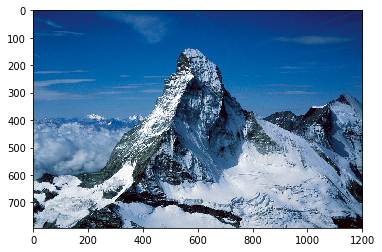

In [161]:
# Read an image using skimage
from skimage import io
image = io.imread('/users/chi/desktop/data586/matterhorn1.jpg') # Add the path to your image
print(image.shape)
# Display an image
plt.imshow(image)
plt.show()

## Basic Pytorch Model

In [162]:

# resources https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/
# resources https://blog.algorithmia.com/convolutional-neural-nets-in-pytorch/

# copied the exact same basic pytorch neural network in the tutorial given and changed the name to BasicCNNModule
# It would be easier this way to follow the tutorial and continue on in task1 
class BasicCNNModule(nn.Module):
    def __init__(self):
        super(BasicCNNModule, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
        
    def backward(self, delta):
        n = len(self.__layers)

        for i in self.__layers[::-1]:
            delta = self.__layers[i].backward(delta)

        return
        

# Coding Task 1 (25 Points)

## Now write a piece of code to train the above designed CNN Model using MNIST images. You can modify the architecture of the network as well if you would like.


MNIST Images: http://yann.lecun.com/exdb/mnist/
A very useful blog for this lab would be https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/ to get the full model running.

*Part marks will be awarded for partially working code

#### Feel free to use any online resource to complete this task, just make sure your put the link to all the resources that you used to solve this part of the assignment.

# Note: I basically copied this and tried to understand what its doing 
* https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/

* the code for importing mnist came from previous lab

In [163]:
# This code was copied from the previous lab 



import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torchvision import transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import time

train = MNIST('./data', train=True, download=True, transform=transforms.ToTensor())

test = MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

cuda = torch.cuda.is_available()


dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda \
                        else dict(shuffle=True, batch_size=64)
trainLoader = dataloader.DataLoader(train, **dataloader_args)
testLoader =dataloader.DataLoader(test, **dataloader_args)

In [164]:
# Since we called it BasicCNNModule we will just change that 

model = BasicCNNModule()
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [165]:
# Train the model
total_step = len(trainLoader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainLoader):
        # Run the forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/5], Step [100/938], Loss: 0.2330, Accuracy: 89.06%
Epoch [1/5], Step [200/938], Loss: 0.0803, Accuracy: 98.44%
Epoch [1/5], Step [300/938], Loss: 0.1211, Accuracy: 96.88%
Epoch [1/5], Step [400/938], Loss: 0.0543, Accuracy: 98.44%
Epoch [1/5], Step [500/938], Loss: 0.0216, Accuracy: 98.44%
Epoch [1/5], Step [600/938], Loss: 0.1309, Accuracy: 95.31%
Epoch [1/5], Step [700/938], Loss: 0.1019, Accuracy: 96.88%
Epoch [1/5], Step [800/938], Loss: 0.1015, Accuracy: 96.88%
Epoch [1/5], Step [900/938], Loss: 0.0731, Accuracy: 95.31%
Epoch [2/5], Step [100/938], Loss: 0.1064, Accuracy: 93.75%
Epoch [2/5], Step [200/938], Loss: 0.0948, Accuracy: 95.31%
Epoch [2/5], Step [300/938], Loss: 0.0253, Accuracy: 98.44%
Epoch [2/5], Step [400/938], Loss: 0.0793, Accuracy: 96.88%
Epoch [2/5], Step [500/938], Loss: 0.0157, Accuracy: 100.00%
Epoch [2/5], Step [600/938], Loss: 0.0638, Accuracy: 98.44%
Epoch [2/5], Step [700/938], Loss: 0.0021, Accuracy: 100.00%
Epoch [2/5], Step [800/938], Loss: 0.0

# Test the module after training 

In [166]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testLoader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

Test Accuracy of the model on the 10000 test images: 99.2 %


# Coding Task 2 (25 Points)

## Please see below the section on Pre-Trained Models and how they can be used as feature extractors. You should now use any pre-trained model such as the one shown below and extract features of an image of your choice and develop a simple  classifer using softmax, MLP or any other one you may want. Keep in mind the input image size before training your model.

A very useful blog post for completing this piece of code would be https://medium.com/@tsakunelsonz/loading-and-training-a-neural-network-with-custom-dataset-via-transfer-learning-in-pytorch-8e672933469

## For more interested people - Bonus Points may be given

Review this blog post where VGGFace is used for face detection http://www.robots.ox.ac.uk/~albanie/pytorch-models.html

Use this extract features of facial images. You may use any open source image from the internet to demonstrate that it works. 

*Part marks will be awarded for partially working code

#### Feel free to use any online resource to complete this task, just make sure your put the link to all the resources that you used to solve this part of the assignment.

# Resources Used
* https://medium.com/@tsakunelsonz/loading-and-training-a-neural-network-with-custom-dataset-via-transfer-learning-in-pytorch-8e672933469

* https://medium.com/@tsakunelsonz/adding-custom-made-images-using-data-loaders-for-transfer-learning-in-five-steps-9d879bb5b80e

* Used the dog and cat data set https://www.kaggle.com/c/dogs-vs-cats/data
* I shortened the data set so run time wont be that long 
* We would be classifying dogs and cats


# Loading the data

In [167]:
# Resource for this part: https://medium.com/@tsakunelsonz/loading-and-training-a-neural-network-with-custom-dataset-via-transfer-learning-in-pytorch-8e672933469
# basically followed the steps in the blog and changed the data set (images)

# 2. Import required Libraries
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms, datasets

#3. Transform the sample data classes using transforms from torchvision
train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.CenterCrop(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
])

#4. Create the dataset with the applied transformations
train_data = datasets.ImageFolder("/users/chi/desktop/data586//dogcat_data//train", transform= train_transform)

# We dont define another validation_transform cuz there is no point just 
# use the previously defined validation transform
validation_data = datasets.ImageFolder("/users/chi/desktop/data586/dogcat_data/validation", transform=train_transform)

# test data 
test_data = datasets.ImageFolder("/users/chi/desktop/data586/dogcat_data/test", transform=train_transform)

#5. Create each data loader from its respective data set
# we change the name from train_loader to trainLoader cuz this the same name he will be using in the latter code

trainLoader = torch.utils.data.DataLoader(train_data, batch_size = 30, shuffle = True)
validLoader = torch.utils.data.DataLoader(validation_data, batch_size = 30, shuffle = False)
testLoader = torch.utils.data.DataLoader(validation_data, batch_size = 30, shuffle = False)

# The datasets must be ordered in a way that pytorch accepts 
# it will have a test train validation folers and in each folder I have 
# a cat folder and dog folder the images must not be the same in the three folders


## Pre-trained models

Training CNN models from scratch requires a lot of data. Hence we often use pre-trained models to alleviate this problem. For CNNs, pre-trained models are readily available for famos architectures such as VGG, ResNet and Inception Net.

When you set `pretrained=True`, torchvision automatically downloads the model for you, and initializes weights from there. If this does not work, run the following:
```
>> wget https://download.pytorch.org/models/vgg16-397923af.pth
>> mv vgg16-397923af.pth ~/.torch/models/vgg16-397923af.pth
```

You can find all other pretrained models included at https://pytorch.org/docs/stable/torchvision/models.html.

In [168]:
# 1. Loading the Neural Network model

# I will keep following how the blog did it 
# Resource 2: https://medium.com/@tsakunelsonz/loading-and-training-a-neural-network-with-custom-dataset-via-transfer-learning-in-pytorch-8e672933469

#import models from torchvision
from torchvision import models
#build the pretrained model (vgg16 in this case)
model = models.vgg16(pretrained = True)

# change vgg16 to model so we can print out 
model.eval()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [169]:
# 2. Building the Classifier and training the Network
#import OrderedDicted to corectly align the network layers
#import nn you use activation and dropout features
from collections import OrderedDict
from torch import nn
#create classifier
classifier=nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 512)),
                           ('relu', nn.ReLU()), 
                           ('dropout', nn.Dropout(p=0.337)),
                           ('fc2', nn.Linear(512, 102)),
                           ('output', nn.LogSoftmax(dim=1))
                             ]))
#replace the model's classifier with this new classifier 
#transfer learning connection applied here
model.classifier = classifier


In [170]:
#import optimizer for 
from torch import optim
#define criteria and optimizer
criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.005, momentum = 0.5)

#The above code snippet sets the learning rate to 0.005 
#(the step size taken by a model to minimize loss and update 
#weights with the goal to improve predictive accuracy) and momentum 
#of 0.5 (the amount by which a model can easily bump off any local minima during the 
#gradient descent process while searching for the global minimum).

### So we can change the learning depending on our data 

# The first is the training function
* which takes in the defined model, the dataset (training Loader) and the loss criterion, then returns the loss and accuracy achieved for each epoch as follows:

In [171]:
#define training function
def train (model, loader, criterion, gpu):
    model.train()
    current_loss = 0
    current_correct = 0
    for train, y_train in iter(loader):
        if gpu:
            train, y_train = train.to('cuda'), y_train.to('cuda')
        optimizer.zero_grad()
        output = model.forward(train)
        _, preds = torch.max(output,1)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()*train.size(0)
        current_correct += torch.sum(preds == y_train.data)
    epoch_loss = current_loss / len(trainLoader.dataset)
    epoch_acc = current_correct.double() / len(trainLoader.dataset)
        
    return epoch_loss, epoch_acc

# The second is the validation function
* which takes in the defined model, the dataset (validation Loader) and the loss criterion; it also returns the loss and accuracy for each epoch as follows:

In [172]:
#define validation function
def validation (model, loader, criterion, gpu):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    for valid, y_valid in iter(loader):
        if gpu:
            valid, y_valid = valid.to('cuda'), y_valid.to('cuda')
        output = model.forward(valid)
        valid_loss += criterion(output, y_valid).item()*valid.size(0)
        equal = (output.max(dim=1)[1] == y_valid.data)
        valid_correct += torch.sum(equal)#type(torch.FloatTensor)
    
    epoch_loss = valid_loss / len(validLoader.dataset)
    epoch_acc = valid_correct.double() / len(validLoader.dataset)
    
    return epoch_loss, epoch_acc

# combine both functions in a loop for the number of epochs times (10 in this case)

In [173]:
import os
import time
import glob

#Initialize training params  
#freeze gradient parameters in pretrained model
for param in model.parameters():
    param.require_grad = False
    
#train and validate
epochs = 10
epoch = 0


#send model to GPU
#if args.gpu:
    #model.to('cuda')
# no gpu so just set cuda = False 
    
for e in range(epochs):
    epoch +=1
    print(epoch)
    with torch.set_grad_enabled(True):
        epoch_train_loss, epoch_train_acc = train(model,trainLoader, criteria, gpu = False)
        print("Epoch: {} Train Loss : {:.4f}  Train Accuracy: {:.4f}".format(epoch,epoch_train_loss,epoch_train_acc))
    
    with torch.no_grad():
        epoch_val_loss, epoch_val_acc = validation(model, validLoader, criteria, gpu = False)
        print("Epoch: {} Validation Loss : {:.4f}  Validation Accuracy {:.4f}".format(epoch,epoch_val_loss,epoch_val_acc))
        
        
        
        
        
        
        

1
Epoch: 1 Train Loss : 1.0125  Train Accuracy: 0.6241
Epoch: 1 Validation Loss : 0.5716  Validation Accuracy 0.7468
2
Epoch: 2 Train Loss : 0.6635  Train Accuracy: 0.6741
Epoch: 2 Validation Loss : 0.6003  Validation Accuracy 0.7468
3
Epoch: 3 Train Loss : 0.6445  Train Accuracy: 0.6848
Epoch: 3 Validation Loss : 0.6386  Validation Accuracy 0.7468
4
Epoch: 4 Train Loss : 0.6332  Train Accuracy: 0.6944
Epoch: 4 Validation Loss : 0.5722  Validation Accuracy 0.7468
5
Epoch: 5 Train Loss : 0.6498  Train Accuracy: 0.6912
Epoch: 5 Validation Loss : 0.6984  Validation Accuracy 0.7029
6
Epoch: 6 Train Loss : 0.6251  Train Accuracy: 0.7093
Epoch: 6 Validation Loss : 0.5930  Validation Accuracy 0.7468
7
Epoch: 7 Train Loss : 0.6292  Train Accuracy: 0.7114
Epoch: 7 Validation Loss : 0.5692  Validation Accuracy 0.7468
8
Epoch: 8 Train Loss : 0.6128  Train Accuracy: 0.6976
Epoch: 8 Validation Loss : 0.5865  Validation Accuracy 0.7468
9
Epoch: 9 Train Loss : 0.6271  Train Accuracy: 0.7082
Epoch: 9 

# Accuracy pretty high since I still used a lot of training data

# Testing the Modified Network
### I created a test folder in the dogs and cats folder with images not in either the validation nor the train folder

In [174]:
model.eval()
total = 0
correct = 0 
count = 0
#iterating for each sample in the test dataset once
for test, y_test in iter(testLoader):
    test, y_test = test.to('cpu'), y_test.to('cpu')
#Calculate the class probabilities (softmax) for img
    with torch.no_grad():
        output = model.forward(test)
        ps = torch.exp(output)
        _, predicted = torch.max(output.data,1)
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item() 
        count += 1
        print("Accuracy of network on test images is ... {:.4f}....count: {}".format(100*correct/total,  count ))

Accuracy of network on test images is ... 0.0000....count: 1
Accuracy of network on test images is ... 0.0000....count: 2
Accuracy of network on test images is ... 0.0000....count: 3
Accuracy of network on test images is ... 0.0000....count: 4
Accuracy of network on test images is ... 0.0000....count: 5
Accuracy of network on test images is ... 13.3333....count: 6
Accuracy of network on test images is ... 25.7143....count: 7
Accuracy of network on test images is ... 35.0000....count: 8
Accuracy of network on test images is ... 42.2222....count: 9
Accuracy of network on test images is ... 48.0000....count: 10
Accuracy of network on test images is ... 52.7273....count: 11
Accuracy of network on test images is ... 56.6667....count: 12
Accuracy of network on test images is ... 60.0000....count: 13
Accuracy of network on test images is ... 62.8571....count: 14
Accuracy of network on test images is ... 65.3333....count: 15
Accuracy of network on test images is ... 67.5000....count: 16
Accura

## We can build a VGG feature extractor. These are often useful in downstream tasks, for example learning deep visual semantic embeddings (https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/41473.pdf). This allows us to use features trained on large datasets like ImageNet, and use on tasks which have lesser data.

## ``` vgg16.features ``` gives us convolutional features. Often, even taking all the layers until the last classification layer also suffices.


In [175]:
vgg16_feature_extractor = model.features
# change to model.features 
# since thats what we did in the previous code it is no longer vgg16 but model 


# print('VGG feature extractor', vgg16_feature_extractor)
print(vgg16_feature_extractor(Variable(torch.rand(1, 3, 224, 224))).size())
print(vgg16_feature_extractor(Variable(torch.rand(1, 3, 224, 224))).view(1, -1).size()) # flatten conv features


# We have our new classifier 
vgg16_4096 = models.vgg16(pretrained=True)
new_classifier = nn.Sequential(*list(vgg16_4096.classifier.children())[:-1]) # remove just the last layer
vgg16_4096.classifier = new_classifier
print(vgg16_4096(Variable(torch.rand(1, 3, 224, 224))).size())

# and our new criteria and optmizer 
criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16_4096.parameters(), lr = 0.005, momentum = 0.5)

torch.Size([1, 512, 7, 7])
torch.Size([1, 25088])
torch.Size([1, 4096])


# after getting the new classifier, criteria and optmiizaer (criteria is the same actually) we run the same code above train/validation and loop for 10 epochs

In [176]:
def train (model, loader, criterion, gpu):
    model.train()
    current_loss = 0
    current_correct = 0
    for train, y_train in iter(loader):
        if gpu:
            train, y_train = train.to('cuda'), y_train.to('cuda')
        optimizer.zero_grad()
        output = model.forward(train)
        _, preds = torch.max(output,1)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()*train.size(0)
        current_correct += torch.sum(preds == y_train.data)
    epoch_loss = current_loss / len(trainLoader.dataset)
    epoch_acc = current_correct.double() / len(trainLoader.dataset)
        
    return epoch_loss, epoch_acc

def validation (model, loader, criterion, gpu):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    for valid, y_valid in iter(loader):
        if gpu:
            valid, y_valid = valid.to('cuda'), y_valid.to('cuda')
        output = model.forward(valid)
        valid_loss += criterion(output, y_valid).item()*valid.size(0)
        equal = (output.max(dim=1)[1] == y_valid.data)
        valid_correct += torch.sum(equal)#type(torch.FloatTensor)
    
    epoch_loss = valid_loss / len(validLoader.dataset)
    epoch_acc = valid_correct.double() / len(validLoader.dataset)
    
    return epoch_loss, epoch_acc

for param in model.parameters():
    param.require_grad = False
    
epochs = 10
epoch = 0
    
for e in range(epochs):
    epoch +=1
    print(epoch)
    with torch.set_grad_enabled(True):
        epoch_train_loss, epoch_train_acc = train(model,trainLoader, criteria, gpu = False)
        print("Epoch: {} Train Loss : {:.4f}  Train Accuracy: {:.4f}".format(epoch,epoch_train_loss,epoch_train_acc))
    
    with torch.no_grad():
        epoch_val_loss, epoch_val_acc = validation(model, validLoader, criteria, gpu = False)
        print("Epoch: {} Validation Loss : {:.4f}  Validation Accuracy {:.4f}".format(epoch,epoch_val_loss,epoch_val_acc))

1
Epoch: 1 Train Loss : 0.5916  Train Accuracy: 0.7146
Epoch: 1 Validation Loss : 0.5600  Validation Accuracy 0.7468
2
Epoch: 2 Train Loss : 0.5846  Train Accuracy: 0.7146
Epoch: 2 Validation Loss : 0.5601  Validation Accuracy 0.7468
3
Epoch: 3 Train Loss : 0.5908  Train Accuracy: 0.7146
Epoch: 3 Validation Loss : 0.5605  Validation Accuracy 0.7468
4
Epoch: 4 Train Loss : 0.5893  Train Accuracy: 0.7146
Epoch: 4 Validation Loss : 0.5620  Validation Accuracy 0.7468
5
Epoch: 5 Train Loss : 0.5961  Train Accuracy: 0.7146
Epoch: 5 Validation Loss : 0.5609  Validation Accuracy 0.7468
6
Epoch: 6 Train Loss : 0.5905  Train Accuracy: 0.7146
Epoch: 6 Validation Loss : 0.5584  Validation Accuracy 0.7468
7
Epoch: 7 Train Loss : 0.5879  Train Accuracy: 0.7146
Epoch: 7 Validation Loss : 0.5609  Validation Accuracy 0.7468
8
Epoch: 8 Train Loss : 0.5901  Train Accuracy: 0.7146
Epoch: 8 Validation Loss : 0.5607  Validation Accuracy 0.7468
9
Epoch: 9 Train Loss : 0.5876  Train Accuracy: 0.7146
Epoch: 9 

# Higher accuracy? 

# Lastly, repeat the same steps as before test the module for accuracy 

In [177]:
model.eval()
total = 0
correct = 0 
count = 0
#iterating for each sample in the test dataset once
for test, y_test in iter(testLoader):
    test, y_test = test.to('cpu'), y_test.to('cpu')
#Calculate the class probabilities (softmax) for img
    with torch.no_grad():
        output = model.forward(test)
        ps = torch.exp(output)
        _, predicted = torch.max(output.data,1)
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item() 
        count += 1
        print("Accuracy of network on test images is ... {:.4f}....count: {}".format(100*correct/total,  count ))

Accuracy of network on test images is ... 0.0000....count: 1
Accuracy of network on test images is ... 0.0000....count: 2
Accuracy of network on test images is ... 0.0000....count: 3
Accuracy of network on test images is ... 0.0000....count: 4
Accuracy of network on test images is ... 0.0000....count: 5
Accuracy of network on test images is ... 13.3333....count: 6
Accuracy of network on test images is ... 25.7143....count: 7
Accuracy of network on test images is ... 35.0000....count: 8
Accuracy of network on test images is ... 42.2222....count: 9
Accuracy of network on test images is ... 48.0000....count: 10
Accuracy of network on test images is ... 52.7273....count: 11
Accuracy of network on test images is ... 56.6667....count: 12
Accuracy of network on test images is ... 60.0000....count: 13
Accuracy of network on test images is ... 62.8571....count: 14
Accuracy of network on test images is ... 65.3333....count: 15
Accuracy of network on test images is ... 67.5000....count: 16
Accura

# Bonus using VGG face 
* Resources: https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/
* probably wont do it

from keras.models import model_from_json
model.load_weights('vgg_face_weights.h5')

vgg_face_descriptor = model(inputs=model.layers[0].input, outputs=model.layers[-2].output)